<a href="https://colab.research.google.com/github/StanleyLiangYork/TensorFlow_For_Image/blob/master/Residual_Networks_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
import tensorflow.keras.backend as K

K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


In [2]:
print(tf.__version__)

2.2.0


*The identity block*

In [0]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', 
               name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid',
               name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut]) 
    X = Activation('relu')(X)
    
    return X

**The convolutional block**

In [0]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a',
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters =F2, kernel_size =(f, f), strides = (1,1), 
               padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters =F3, kernel_size =(1, 1), strides = (1,1), padding = 'valid', 
               name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters =F3, kernel_size =(1, 1), strides = (s,s), padding = 'valid',
                        name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut]) 
    X = Activation('relu')(X)
    
    return X

**Building the ResNet model**

In [0]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (3, 3), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), name = 'avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [0]:
model = ResNet50(input_shape = (32, 32, 3), classes = 3)

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Download the 3-class dataset

In [0]:
import os
from numpy import load

if not os.path.exists('malaria_3_class_data.npz'):
    !gsutil cp gs://pet-detect-239118/malaria_3_class_data.npz ./malaria_3_class_data.npz


# load the real images
def load_dataset():
   data = load('./malaria_3_class_data.npz')
   X = data['arr_0']
   Y = data['arr_1']
   return X, Y

In [18]:
from sklearn.model_selection import train_test_split
X, Y = load_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=100)
print(X_train.shape)
print(X_test.shape)

(29784, 32, 32, 3)
(7446, 32, 32, 3)


In [0]:
def prep_pixels(train, test):
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0
  return train_norm, test_norm

In [0]:
from matplotlib import pyplot as plt

def summarize_diagnostics(history):
  plt.figure(figsize=(10, 10))
  # plot loss
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], color='blue', label='Training')
  plt.plot(history.history['val_loss'], color='orange', label='Test')
  plt.legend(loc='lower right')
  plt.title('Cross Entropy Loss')
  # plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], color='blue', label='Training')
  plt.plot(history.history['val_accuracy'], color='orange', label='Test')
  plt.legend(loc='lower right')
  plt.title('Classification Accuracy')
  plt.show()

In [30]:
trainX, testX = prep_pixels(X_train, X_test)
history = model.fit(trainX, y_train, epochs=30, batch_size=256, validation_data=(testX, y_test), verbose=2)
loss, acc = model.evaluate(testX, y_test, verbose=0)
print("loss: {:6.3f}, accuracy: {:6.3f}%".format(loss, acc*100))


Epoch 1/30
117/117 - 3s - loss: 0.0072 - accuracy: 0.9973 - val_loss: 0.1460 - val_accuracy: 0.9743
Epoch 2/30
117/117 - 3s - loss: 0.0074 - accuracy: 0.9974 - val_loss: 0.1083 - val_accuracy: 0.9786
Epoch 3/30
117/117 - 3s - loss: 0.0037 - accuracy: 0.9987 - val_loss: 0.0978 - val_accuracy: 0.9804
Epoch 4/30
117/117 - 3s - loss: 0.0039 - accuracy: 0.9986 - val_loss: 0.1845 - val_accuracy: 0.9713
Epoch 5/30
117/117 - 3s - loss: 0.0084 - accuracy: 0.9969 - val_loss: 0.1128 - val_accuracy: 0.9735
Epoch 6/30
117/117 - 3s - loss: 0.0054 - accuracy: 0.9981 - val_loss: 0.1187 - val_accuracy: 0.9745
Epoch 7/30
117/117 - 3s - loss: 0.0029 - accuracy: 0.9991 - val_loss: 0.1182 - val_accuracy: 0.9813
Epoch 8/30
117/117 - 3s - loss: 0.0064 - accuracy: 0.9981 - val_loss: 0.4405 - val_accuracy: 0.9424
Epoch 9/30
117/117 - 3s - loss: 0.0092 - accuracy: 0.9969 - val_loss: 0.1345 - val_accuracy: 0.9746
Epoch 10/30
117/117 - 3s - loss: 0.0030 - accuracy: 0.9991 - val_loss: 0.9286 - val_accuracy: 0.8380

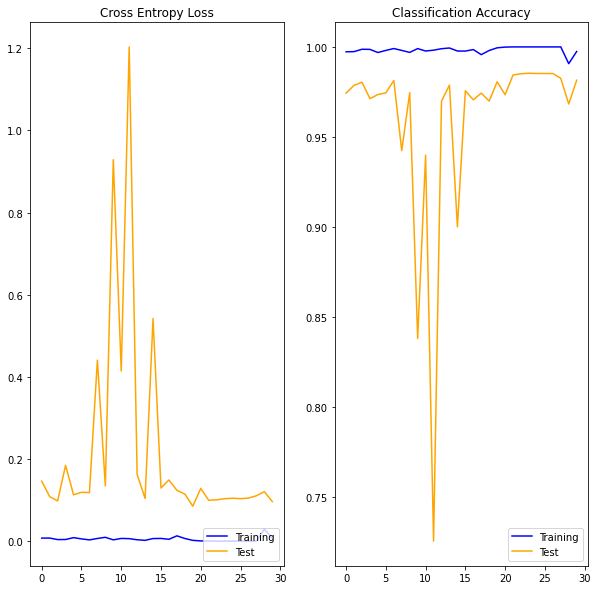

In [31]:
summarize_diagnostics(history)

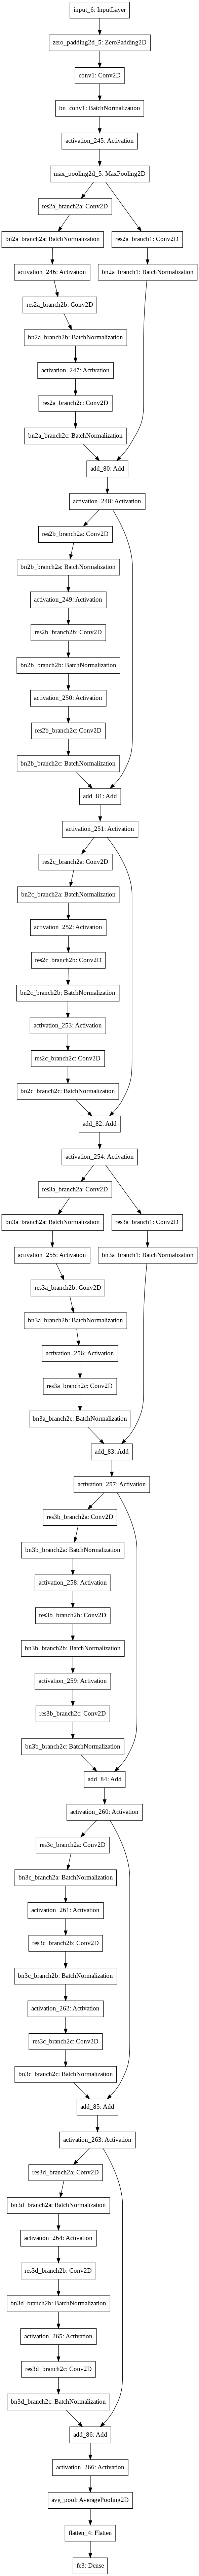

In [32]:
from tensorflow.keras.utils import plot_model
plot_model(model)